# Land Cover Pixel Drill

## Background 
Land Cover is the observed biophisical cover of the earth's surface. the Digital Earth Australia Landcover product classifies the Australian continent's surface into the [**FAO LCCS taxonomy**](https://www.fao.org/3/x0596e/x0596e00.htm), providing detailed information on the presance of water, vegetation cover and the urban environment. For a more indepth intorduction into DEA Land Cover dataset see the introductory notebook.

Trends in land Cover over time provide important infomration about environmental conditions and human activity. For example measuring change in land cover over time can describe the natural cycles of greening and drying in an ephemeral wetland or show how an ecosystem responds after a bushfire.

## Description 

A pixel drill is a method of analysig time-deep satelite data; a single spatial point is chosen and the characteristics of that point though time are plotted. This notebook conducts a pixel drill on the Basic layer of the Digital Earth Australia Landcover product, which contains six layers, visualising how a single point on Australia's surface has or has not changed over 30 + years. 

1. Select and area of interst and load data
2. Visualise the data and select point for pixel drill
3. Conduct pixel drill 
4. Plot land cover history of the chosen point

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load Packages

In [1]:
%matplotlib widget

import datacube
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import rgb
from matplotlib import colors as mcolours
from IPython.display import Image
from dea_tools.plotting import xr_animation, rgb
import matplotlib.patheffects as PathEffects
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import MaxNLocator
from dea_tools.plotting import display_map
import datacube

In [2]:
dc = datacube.Datacube()

### Define custom fuctions

This notbook uses a few custom fuctions 

In [3]:
#define custom fuctions

def rescale_level3(data):
    """rescale distribution of level three classes to be 0-6 for neat plotting in pixel drill plot
    Input : xarray DataSet or DataArray containing level 3 land cover data
    """
    scale_and_lables = {0:0, 111: 1, 112:2, 124:3, 215:4, 216:5, 220:6}

    for key, value in scale_and_lables.items():
                        data = data.where(data!= key, value)
    return(data)

def click_for_coords(event):
    """
    Define behavior widget to enable extraction of x,y values for point manually selected with mouse click on interactive plot
    For use with Matplotlib Imshow.
    the x and y returned are the coordinate possitions of the pixel in the x and y axies, rather than latitude/logitude values of the point.
    the coordinate possitions of the pixel this is what you need latter to conduct a pixel drill.
    returns:
    ix, iy = position of selected pixel in the x and y coordinates of the array
    """
    global ix, iy
    ix, iy = event.xdata, event.ydata
    global coords
    coords.append((ix, iy))

    fig.canvas.mpl_disconnect(cid)
    return

def create_colour_map(colours):
    """create colour map and normalisation for plotting Land Cover layers
    input:
    dict, a dictionary defining the class numbers and corrosponding RGB(A) colour values for the land cover layer to be plotted.
    returns:
    cmap, norm : Matplotlib colour map and colour map nornmalisation 
    """
    colour_arr = []
    cblabels = []
    for key, value in colours.items():
        colour_arr.append(np.array(value[:-2])/255)
        cblabels.append(value[-1])

    cmap = mcolours.ListedColormap(colour_arr)
    bounds = list(colours)
    bounds.append(255)
    norm = mcolours.BoundaryNorm(np.array(bounds) - 0.1, cmap.N)
    return cmap, norm

In [4]:
#define level three colourcheme

LEVEL3_COLOUR_SCHEME = { 0   : (255, 255, 255, 255, "No Data"),
                         111 : (172, 188, 45, 255, "Cultivated Terrestrial Vegetation"),
                         112 : (14, 121, 18, 255, "Natural Terrestrial Vegetation"),
                         124 : (30, 191, 121, 255, "Natural Aquatic Vegetation"),
                         215 : (218, 92, 105, 255, "Artificial Surface"),
                         216 : (243, 171, 105, 255, "Natural Bare Surface"),
                         220 : (77, 159, 220, 255, "Water")}

## 1. Define area of interest and load data

In [5]:
#select a center point for an AOI 

#lake George
point_x, point_y = (-35.1064, 149.4248)


lat = (point_x-0.1, point_x+0.1)
lon = (point_y-0.1, point_y+0.1)

#display area on map
display_map(x=lon, y=lat)


In [6]:
query = {
    'y': lat,
    'x': lon,
    'time': ('1988', '2020'),
}

# Load DEA Land Cover data from the datacube
all_data = dc.load(product='ga_ls_landcover_class_cyear_2',
#              crs = "EPSG:3577",
             output_crs='EPSG:3577',
              measurements=['level3'],
             resolution=(-25, 25),
             **query)

In [7]:
#have a look at the data we loaded

all_data

<xarray.Dataset>
Dimensions:      (time: 33, y: 982, x: 842)
Coordinates:
  * time         (time) datetime64[ns] 1988-01-01 1989-01-01 ... 2020-01-01
  * y            (y) float64 -3.93e+06 -3.93e+06 ... -3.954e+06 -3.954e+06
  * x            (x) float64 1.569e+06 1.569e+06 1.569e+06 ... 1.59e+06 1.59e+06
    spatial_ref  int32 3577
Data variables:
    level3       (time, y, x) uint8 112 112 112 112 111 ... 112 112 112 112 112
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [8]:
#select level 3
level3 = all_data.level3

## 2. Visualise the data and select point for pixel drill

This plot has a interactive fuction enabled which allows users to select a specific point to analyse in greater detail further down the notebook. To use this feature select a poin on the plot you wish to interrogate by clicking on it with your mouse. Then run the next code cell bellow. The point you selected will then be highlighted on this plot with a red dot.

The Most recent year has been set as default to visualise in this step

#### trouble shooting:
You can move the dot by clicking on a new location and then re-running the next cell after the interactive plot again. Unless you have since completed the notebook and generated the graph at the end, in which case you need to re-run this code first in order to re-generate the interactive plot before selecting a new point.

If you click multible times on the plot before running the next pice of code only the most recent location will be used.

If you run into trouble restarting the kernal of the notebook and runing form the first cell again may help.

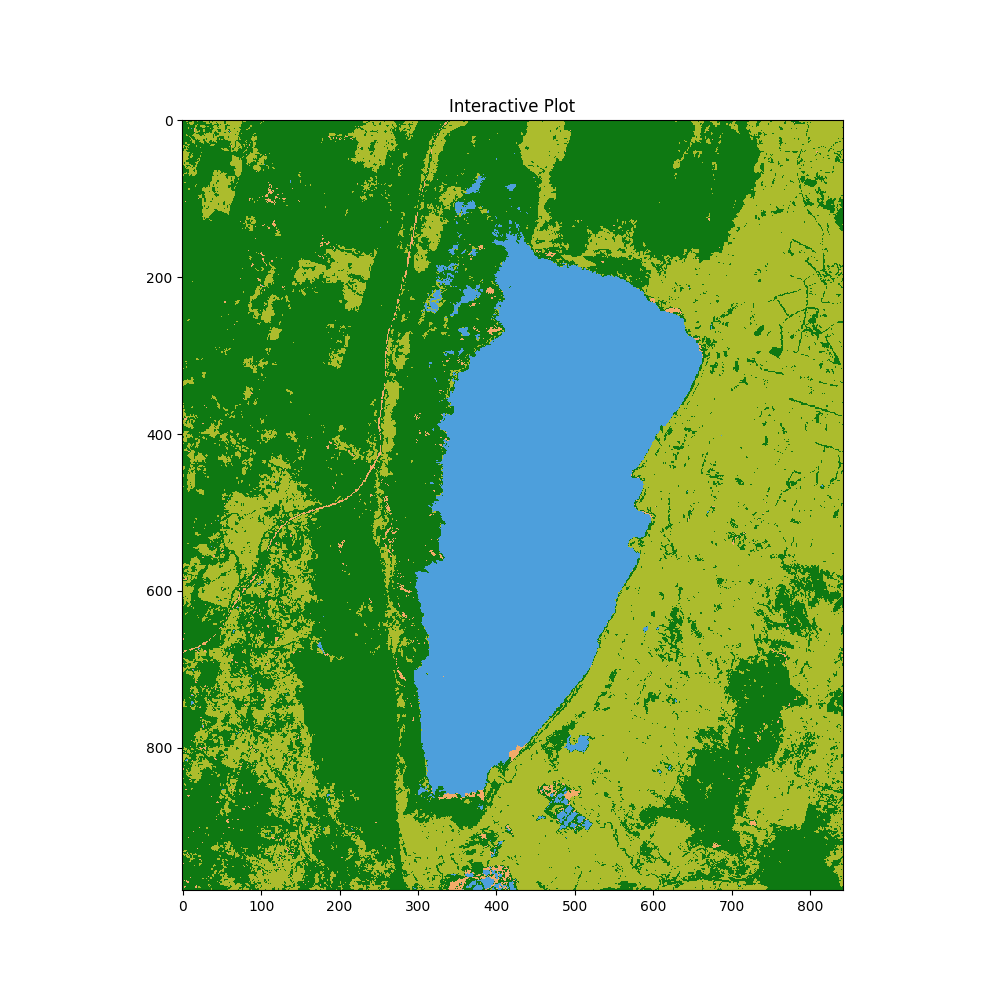

In [9]:
#build the colour map for level 3
layer_cmap, layer_norm = create_colour_map(LEVEL3_COLOUR_SCHEME)

#select year to plot
plot_year = '2020'

#create interactive plot
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(level3.sel(time=plot_year, method="nearest").squeeze(), cmap=layer_cmap, norm=layer_norm, interpolation="nearest")
cid = fig.canvas.mpl_connect('button_press_event', click_for_coords)
plt.title("Interactive Plot")

plt.show()

### Run next cell to **enter** or **update** Selected point

In [10]:
# Enter selected point
plt.clf()
ax = plt.imshow(level3.sel(time=plot_year, method="nearest").squeeze(), cmap=layer_cmap, norm=layer_norm, interpolation="nearest")
plt.scatter(x =ix, y=iy, c='r', s = 80)


NameError: name 'ix' is not defined

#### Trouble shooting:
If an error is appearing above this test saying <code><span style="color:red">NameError</span>: name 'ix' is not defined</code> You have not chosen a point to conduct the pixel drill on or entered it. Please select a point on the interactive plot and run the cell above to enter the point.

## 3. Conduct pixel drill

In [ ]:
#find nearest whole number value for v,y
xcoord = int(ix)
ycoord = int(iy)

#conduct pixel drill on loaded dataset
pixel_timeseries= level3.isel(x=xcoord, y=ycoord,)

#rescale the range of Level 3 classes for beautiful plotting
new_data = rescale_level3(pixel_timeseries)

## 4. Plot land cover history of the chosen point

In [ ]:
#define new figure and plot
fig, ax = plt.subplots(figsize=(10,4))
number_labels = (0, 1, 2, 3, 4, 5, 6)
label_classes = ('No Data', 'Cultivated Terrestrial\n Vegetation', 'Natural Terrestrial\n Vegetation', 
                 'Natural Aquatic\n Vegetation', 'Artificial Surface', 'Natural Bare\n Surface', 'Water')

plt.yticks(number_labels, label_classes)#make lables be class names
new_data.plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='b')
plt.xlabel("year")
plt.title("Land Cover History for Selected Point")
plt.grid()
plt.tight_layout()
plt.show

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)